This notebook loads the processed historical price data for EUROSTOXX 50 and DAX index options, the pre-decoded factors, and offline-trained checkpoint files for some of the neural network models that are used in the published paper [Estimating Risks of Option Books using Neural-SDE Market Models](https://arxiv.org/abs/2202.07148).


In [1]:
import os
import sys
import random
import warnings
warnings.filterwarnings('ignore')

# add the path of packages to system path
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
# add packages for computation
import pickle
import numpy as np
import pandas as pd
import scipy as sp

import marketmodel.loader as loader

from tqdm.notebook import tqdm
from statsmodels.tsa.arima.model import ARIMA

from marketmodel.loader import DataOm
from marketmodel import utils
from marketmodel import risk
from marketmodel.factors import PrepTrainData, DecodeFactor
from marketmodel.neuralsde import Train, Simulate

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

# Load data

In [2]:
# load OptionMetric data
ls_securityid = ['EX50', 'DAX']
in_dir = '../input/'
dt = 1./365

curr_module = sys.modules[__name__]

ls_X = []
ls_dX = []
ls_S = []
ls_S_test = []
ls_C = []
ls_C_test = []
ls_dates = []
for i_securityid in range(len(ls_securityid)):
    securityid = ls_securityid[i_securityid]
    
    fname = in_dir + f'om_{securityid}.pkl'
    with open(fname, 'rb') as f:
        cache = pickle.load(f)
        
    for k, v in vars(cache).items():
        setattr(curr_module, k, v)
    
    ls_X.append(X)
    ls_dX.append(dX)
    ls_S.append(S)
    ls_S_test.append(S_test)
    ls_C.append(cs)
    ls_C_test.append(cs_test)
    ls_dates.append(dates_train)

# concatenate factor data
X = np.vstack(ls_X)
dX = np.vstack(ls_dX)

## Plot historical prices of EURO STOXX 50 and DAX indices

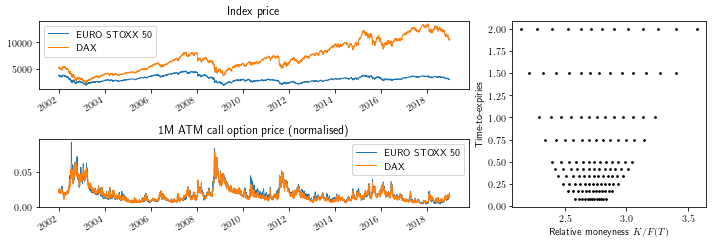

In [3]:
headers = ['EURO STOXX 50', 'DAX']
utils.PlotLib.plot_om2_timeseries(headers, ls_securityid, ls_dates, ls_S, ls_C, Ts, np.exp(ms))

## Plot the decoded factors

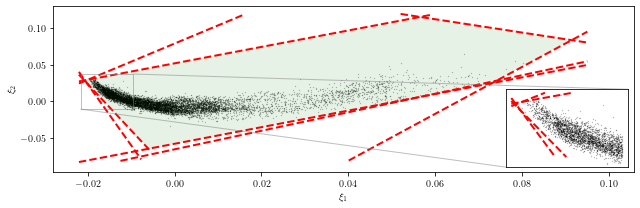

In [4]:
utils.PlotLib.plot_om2_factors(X, W, b)

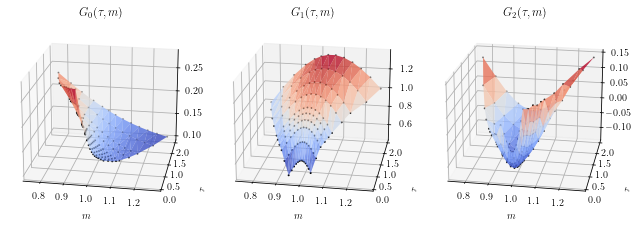

In [5]:
from matplotlib import cm

G_ = G.copy()
for i in range(1, G.shape[0]):
    G_[i] /= cs_weights

fig = plt.figure(figsize=(9, 3))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    ax.set_title(fr'$G_{i}(\tau, m)$')
    ax.scatter(ms, Ts, G_[i], c='k', s=1)
    ax.plot_trisurf(ms, Ts, G_[i], alpha=.8, cmap=cm.coolwarm)
    ax.tick_params(axis='x', which='major', pad=-2)
    ax.tick_params(axis='y', which='major', pad=-2)
    ax.set_xlabel(r'$m$', labelpad=-2)
    ax.set_ylabel(r'$\tau$')
    ax.view_init(20, -80)
    ax.dist = 9

plt.tight_layout()

# Build and train neural-SDE models

## Train a neural-SDE model for S

In [6]:
hp_model_lnS = utils.ConfigOm.hp_model_lnS
model_number = 0
dir_model = '../output/checkpoint_om/'
os.makedirs(dir_model, exist_ok=True)

ls_mu_S = []
ls_res_S = []
ls_model_lnS = []
for i_securityid in range(len(ls_securityid)):
    securityid = ls_securityid[i_securityid]
    S = ls_S[i_securityid]
    dlnS = np.diff(np.log(S))
    mu_S = np.mean(dlnS) / dt  # estimate drift
    ls_mu_S.append(mu_S)
    
    # prepare training data
    X_lnS = ls_X[i_securityid][:-1, :]
    Y_lnS = dlnS.reshape((-1, 1))
    
    # train model or load trained model
    model_name = f'model_lnS_{securityid}'
    model_lnS = Train.train_lnS(
        X_lnS, Y_lnS, mu_S, dt, 
        pruning_sparsity=hp_model_lnS['pruning_sparsity'],
        validation_split=hp_model_lnS['validation_split'],
        batch_size=hp_model_lnS['batch_size'],
        epochs=hp_model_lnS['epochs'],
        rand_seed=model_number, force_fit=False,
        model_name=model_name,
        out_dir=dir_model)
    ls_model_lnS.append(model_lnS)
    
    # compute model residuals
    alpha = model_lnS.predict(X_lnS).T
    sigma_S = np.exp(-0.5 * alpha)
    res_S = (dlnS - mu_S * dt) / sigma_S.ravel()
    ls_res_S.append(res_S)

2022-06-17 17:27:47.725949: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


134/134 [==============================] - 0s 666us/step


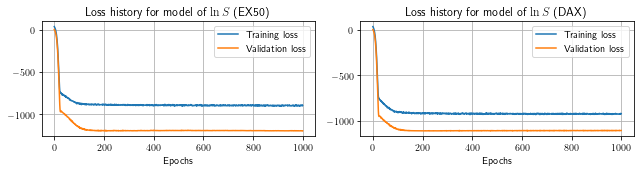

In [7]:
fig = plt.figure(figsize=(9, 2.5))
for i_securityid in range(len(ls_securityid)):
    securityid = ls_securityid[i_securityid]
    df_hist = pd.read_csv(f'{dir_model}model_lnS_{securityid}_{model_number}_history.csv', 
                          index_col=0)
    ax = fig.add_subplot(1, 2, i_securityid + 1)
    ax.set_title(fr'Loss history for model of $\ln S$ ({securityid})')
    ax.plot(df_hist['loss'], label='Training loss')
    ax.plot(df_hist['val_loss'], label='Validation loss')
    ax.set_xlabel('Epochs')
    ax.legend()
    plt.grid()
plt.tight_layout()

## Train a neural-SDE model for factors

In [8]:
# load config
hp_model_xi = utils.ConfigOm.hp_model_xi
hp_sde_transform = utils.ConfigOm.hp_sde_transform

frac_critical_threshold = hp_sde_transform['frac_critical_threshold']
critical_value = hp_sde_transform['critical_value']
proj_scale = hp_sde_transform['proj_scale']
rho_star = hp_sde_transform['rho_star']
epsmu_star = hp_sde_transform['epsmu_star']

n_factor_pri = 2
n_factor_sec = 13
model_number = 9
dir_model = '../output/checkpoint_om/'

# calibrate a hypterparameter for normalising distance
dist_X = np.abs(W.dot(X.T) - b[:, None]) / \
         np.linalg.norm(W, axis=1, keepdims=True)
critical_threshold = frac_critical_threshold * np.min(
    np.max(dist_X, axis=1))
dist_multiplier = (1. / (
        1 - critical_value) - 1) / critical_threshold

# pre-calculate diffusion scaling data
Omegas, det_Omega, proj_dX = PrepTrainData.calc_diffusion_scaling(
    W, b, X, dX, dist_multiplier, proj_scale)

# pre-calculate drift correction data
X_interior, corr_dirs, epsmu = PrepTrainData.calc_drift_correction(
    W, b, X, rho_star, epsmu_star)

# prepare training data
X_xi = X
Y_xi = np.hstack((proj_dX, Omegas, det_Omega, corr_dirs, epsmu))
dim_input = n_factor_pri
dim_output = n_factor_pri + int(0.5 * n_factor_pri * (n_factor_pri + 1))

model_name = 'model_xi'
model_xi = Train.train_xi_endo(
    X_xi, Y_xi, W, dt, 
    pruning_sparsity=hp_model_xi['pruning_sparsity'],
    validation_split=hp_model_xi['validation_split'],
    batch_size=hp_model_xi['batch_size'],
    epochs=hp_model_xi['epochs'],
    rand_seed=9, force_fit=False,
    model_name=model_name,
    out_dir=dir_model)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 8551/8551 [00:00<00:00, 13298.83it/s]


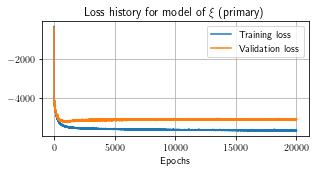

In [9]:
fig = plt.figure(figsize=(4.5, 2.5))
df_hist = pd.read_csv(f'{dir_model}model_xi_{model_number}_history.csv', 
                      index_col=0)
ax = fig.add_subplot(111)
ax.set_title(fr'Loss history for model of $\xi$ (primary)')
ax.plot(df_hist['loss'], label='Training loss')
ax.plot(df_hist['val_loss'], label='Validation loss')
ax.set_xlabel('Epochs')
ax.legend()
plt.grid()
plt.tight_layout()

# Analyse the trained neural-SDE models

## Visualise the learnt drift and diffusion

In [10]:
_, _, mu, _, sigma_L = Train.predict_in_sample_model_xi(model_xi, X_xi, Y_xi, W, endo=True)

268/268 [==============================] - 0s 796us/step


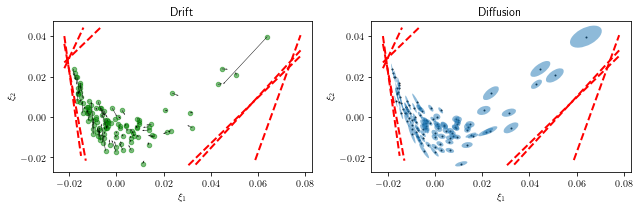

In [11]:
n_plot_points = 110
utils.PlotLib.plot_xi_drift_diffusion_om(X, mu, sigma_L, n_plot_points, W, b)

## Analyse model residuals

In [12]:
# compute residuals for xi
sigma_L_inv = np.linalg.inv(sigma_L)
res_xi = np.squeeze(
    np.matmul(sigma_L_inv, np.expand_dims(dX - mu * dt, axis=-1)))

ls_res_xi_S = []
i_start = 0
for i_securityid in range(len(ls_securityid)):
    i_end = i_start + len(ls_res_S[i_securityid])
    res_xi_S = np.hstack((res_xi[i_start:i_end, :], ls_res_S[i_securityid].reshape((-1,1))))
    ls_res_xi_S.append(res_xi_S)
    i_start = i_end + 1

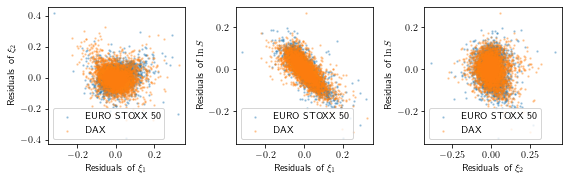

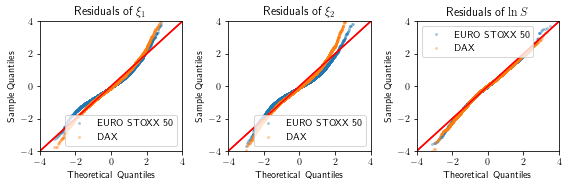

In [13]:
titles = [r'$\xi_1$', r'$\xi_2$', r'$\ln S$']
headers = ['EURO STOXX 50', 'DAX']

import itertools
ls_xi_pair = list(itertools.combinations([0,1,2], 2))

fig = plt.figure(figsize=(8,2.6))
for i in range(3):
    xi_pair = ls_xi_pair[i]
    ax = fig.add_subplot(1,3,i+1)
    for j in range(2):
        res_xi_S = ls_res_xi_S[j]
        ax.scatter(res_xi_S[:, xi_pair[0]], res_xi_S[:, xi_pair[1]], s=2, alpha=.3, label=headers[j])
    ax.set_xlabel('Residuals of ' + titles[xi_pair[0]])
    ax.set_ylabel('Residuals of ' + titles[xi_pair[1]])
    ax.legend()
    
plt.tight_layout()

import statsmodels.api as sm

ls_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig = plt.figure(figsize=(8,2.7))
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    ax.set_title('Residuals of ' + titles[i])
    for j in range(2):
        res_xi_S = ls_res_xi_S[j]
        sm.qqplot(res_xi_S[:,i] / np.sqrt(dt), line='45', markersize=2, 
                  markerfacecolor=ls_colors[j], markeredgecolor=ls_colors[j], 
                  ax=ax, alpha=.3, label=headers[j]);
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4])
    ax.legend()
    
plt.tight_layout()

## Simulate

In [14]:
# simulate factors
np.random.seed(1)
N = 1000
X0 = X[0, :]
xit, mus_sim, vols_sim, n_reflect = Simulate.simulate_xi_lite(
    dt, N, model_xi,
    X0, W, b,
    dist_multiplier, proj_scale,
    rho_star, epsmu_star, X_interior, reflect=True)

# simulate S
i_securityid = 0

model_lnS = ls_model_lnS[i_securityid]
mu_S = ls_mu_S[i_securityid]
S0 = ls_S[i_securityid][0]
st = Simulate.simulate_lnS_lite(dt, N, model_lnS, S0, xit, mu_S)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.92it/s]


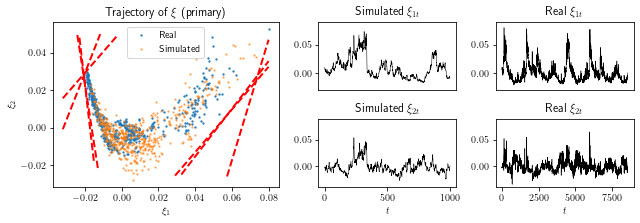

In [15]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(9, 3.2))

gs = GridSpec(2, 7)
ax = fig.add_subplot(gs[:,:3])

ax.set_title(r'Trajectory of $\xi$ (primary)')
ax.set_xlabel(r'$\xi_1$')
ax.set_ylabel(r'$\xi_2$')

np.random.seed(0)
data_mask = np.random.choice(range(N), 500, replace=False)

ax.scatter(X[data_mask,0], X[data_mask,1], s=2, alpha=.8, label='Real')
ax.scatter(xit[0, data_mask], xit[1, data_mask], s=2, alpha=.5, label='Simulated')
ax.legend()

xs = np.linspace(-0.032, 0.08, 100)
j = 0
for i in range(W.shape[0]):
    wi = W[i]
    bi = b[i]
    ys = bi/wi[1] - wi[0]/wi[1] * xs
    mask = (ys<0.05) & (ys>-0.026)
    ax.plot(xs[mask], ys[mask], '--r', linewidth=2)
    j+=1

ax = fig.add_subplot(gs[0, 3:5])
ax.set_title(r'Simulated $\xi_{1t}$')
ax.plot(xit[0], 'k', linewidth=.5)
ax.set_xticks([])
ax.set_ylim([-0.03, 0.09])
ax = fig.add_subplot(gs[1, 3:5])
ax.set_title(r'Simulated $\xi_{2t}$')
ax.plot(xit[1], 'k', linewidth=.5)
ax.set_xlabel(r'$t$')
ax.set_ylim([-0.04, 0.09])

ax = fig.add_subplot(gs[0, 5:])
ax.set_title(r'Real $\xi_{1t}$')
ax.plot(X[:,0], 'k', linewidth=.5)
ax.set_xticks([])
ax.set_ylim([-0.03, 0.09])
ax = fig.add_subplot(gs[1, 5:])
ax.set_title(r'Real $\xi_{2t}$')
ax.plot(X[:,1], 'k', linewidth=.5)
ax.set_xlabel(r'$t$')
ax.set_ylim([-0.04, 0.09])

plt.tight_layout()

# Decode and model secondary factors

In [16]:
norm_factor_sec = hp_sde_transform['norm_factor_sec']

cs_ts_weighted = np.vstack(ls_C) * cs_weights  # vega-weighted normalised call prices
mat_AV = mat_A.dot(np.diag(1. / cs_weights))  # coefficients of no-arbitrage bounds for weighted call prices

# append secondary factors
X_full, G_full, W_full, b_full = DecodeFactor.append_pca_secondary_factors(
    X, G, cs_ts_weighted, n_factor_sec, norm_factor_sec, mat_AV, vec_b)

# fit each secondary factor data to an AR(1) model
ls_xi3_ar_mdl = []
ls_xi3_t_params = []
ls_xi3_stdres = []
for idx_factor in tqdm(range(n_factor_pri, n_factor_pri + n_factor_sec)):
    # get data
    xi3 = X_full[:, idx_factor]
    # fit model
    xi3_ar_mdl = ARIMA(xi3, order=(1, 0, 0))
    xi3_ar_res = xi3_ar_mdl.fit()
    ls_xi3_ar_mdl.append(xi3_ar_res)
    ls_xi3_t_params.append(sp.stats.t.fit(xi3_ar_res.resid))
    ls_xi3_stdres.append(xi3_ar_res.resid)  # model residuals

arr_xi3_const = np.zeros(n_factor_sec)
arr_xi3_coeff = np.zeros(n_factor_sec)
arr_xi3_sigma = np.zeros(n_factor_sec)
for idx_factor in range(n_factor_sec):
    arr_xi3_const[idx_factor] = ls_xi3_ar_mdl[idx_factor].params[0]
    arr_xi3_coeff[idx_factor] = ls_xi3_ar_mdl[idx_factor].params[1]
    arr_xi3_sigma[idx_factor] = np.sqrt(ls_xi3_ar_mdl[idx_factor].params[2])
    
res_xi_sec = np.vstack(ls_xi3_stdres).T

# separate residual data for different securities
ls_res_xi_sec = []
i_start = 0
for i_securityid in range(len(ls_securityid)):
    i_end = i_start + len(ls_res_S[i_securityid])
    ls_res_xi_sec.append(res_xi_sec[i_start:i_end, :])
    i_start = i_end + 1

  0%|          | 0/13 [00:00<?, ?it/s]

/opt/anaconda3/envs/mktmdl/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/mktmdl/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Backtest VaR

In [17]:
i_securityid = 0
mpor = 1  # margin period of risk
n_mktmdl_scenario = 5000  # number of risk scenarios to simulate
out_dir_var_scenario = f'../output/var/scenario_mpor{mpor}/'
if not os.path.exists(out_dir_var_scenario):
    os.makedirs(out_dir_var_scenario, exist_ok=True)

securityid = ls_securityid[i_securityid]

# get test data and nSDE model
S_ts_test = ls_S_test[i_securityid]
cs_ts_test = ls_C_test[i_securityid]
mu_S = ls_mu_S[i_securityid]
model_lnS = ls_model_lnS[i_securityid]
ks = np.exp(ms)

n_test = cs_ts_test.shape[0] - mpor

print(f'Security           = {securityid}')
print(f'MPOR               = {mpor}')
print(f'No. test samples   = {n_test}')
print(f'No. risk scenarios = {n_mktmdl_scenario}')

# generate historical shocks
res_xi_S = ls_res_xi_S[i_securityid]  # residuals of the primary factors and S
res_xi_sec = ls_res_xi_sec[i_securityid]  # residuals of the secondary factors

ls_dW_xi_S = []
ls_dW_xi_sec = []
np.random.seed(0)
idxs_noise_sample = np.random.choice(res_xi_S.shape[0] - mpor,
                                     n_mktmdl_scenario, replace=True)
for p in range(mpor):
    dW_xi_S = res_xi_S[idxs_noise_sample+p, :]
    dW_xi_sec = res_xi_sec[idxs_noise_sample+p, :]
    ls_dW_xi_S.append(dW_xi_S)
    ls_dW_xi_sec.append(dW_xi_sec)

Security           = EX50
MPOR               = 1
No. test samples   = 252
No. risk scenarios = 5000


## Simulate risk scenarios

In [18]:
for t in range(n_test):

    print(f'Calculate scenario prices at time t = {t}.')
    
    fname_base = f'{out_dir_var_scenario}outrights_base_t{t}_{securityid}.csv'
    fname_xi_scenarios = f'{out_dir_var_scenario}xi_scenarios_t{t}_{securityid}.csv'
    fname_c_scenarios = f'{out_dir_var_scenario}normc_scenarios_t{t}_{securityid}.csv'
    fname_S_scenarios = f'{out_dir_var_scenario}S_scenarios_t{t}_{securityid}.csv'
    
    if os.path.exists(fname_base) and os.path.exists(fname_c_scenarios):
        continue

    # get option prices
    S_t = S_ts_test[t]
    cs_t = cs_ts_test[t]
    cs_t_w = cs_t * cs_weights

    # calibrate factors
    xi = risk.calibrate_factors(
        cs_t_w, G_full, W_full, b_full, n_factor_pri, n_factor_sec)
    xi_pri = xi[:n_factor_pri]
    xi_sec = xi[n_factor_pri:]

    # compute realised PnLs
    t_realised = t + mpor
    S_realised = S_ts_test[t_realised]
    cs_realised = cs_ts_test[t_realised]
    Cs, Cs_realised = risk.calculate_base_normc(S_t, cs_t, S_realised, cs_realised, ks, Ts, mpor, dt)

    pd.DataFrame(np.vstack((Cs, Cs_realised)).T, 
                 columns=['base', 'realised']).to_csv(fname_base, index=0)

    # simulate factors

    ## simulate primary factors and S
    xi_pri_scenario, S_scenario = Simulate.simulate_xi_S_scenario_histshocks(
        dt, mpor, model_xi, model_lnS, S_t, xi_pri, mu_S, W, b, ls_dW_xi_S,
        dist_multiplier, proj_scale, rho_star, epsmu_star, X_interior)

    ## simulate secondary factors
    xi_sec_scenario = Simulate.simulate_xi_sec_scenario_histshocks(
                mpor, xi_sec, arr_xi3_const, arr_xi3_coeff, ls_dW_xi_sec)

    xi_scenario = np.hstack((xi_pri_scenario, xi_sec_scenario))

    # inteprolate scenario normalised call prices
    tolerance = 1e-8
    xi_scenario, cs_scenario_decayT, _ = \
        risk.calculate_scenario_normc(
            xi_scenario, S_scenario, G_full, W_full, b_full, S_t, tolerance,
            cs_weights, ks, Ts, mpor, dt, n_factor_pri, n_factor_sec)
    
    pd.DataFrame(xi_scenario).to_csv(fname_xi_scenarios, index=0)
    pd.DataFrame(cs_scenario_decayT).to_csv(fname_c_scenarios, index=0)
    pd.DataFrame(S_scenario).to_csv(fname_S_scenarios, index=0)

Calculate scenario prices at time t = 0.
Calculate scenario prices at time t = 1.
Calculate scenario prices at time t = 2.
Calculate scenario prices at time t = 3.
Calculate scenario prices at time t = 4.
Calculate scenario prices at time t = 5.
Calculate scenario prices at time t = 6.
Calculate scenario prices at time t = 7.
Calculate scenario prices at time t = 8.
Calculate scenario prices at time t = 9.
Calculate scenario prices at time t = 10.
Calculate scenario prices at time t = 11.
Calculate scenario prices at time t = 12.
Calculate scenario prices at time t = 13.
Calculate scenario prices at time t = 14.
Calculate scenario prices at time t = 15.
Calculate scenario prices at time t = 16.
Calculate scenario prices at time t = 17.
Calculate scenario prices at time t = 18.
Calculate scenario prices at time t = 19.
Calculate scenario prices at time t = 20.
Calculate scenario prices at time t = 21.
Calculate scenario prices at time t = 22.
Calculate scenario prices at time t = 23.
Ca

## Compute VaR for various option trading strategies

In [19]:
confidence = 0.99
ls_portfolioname, ls_ts_pnl_, ls_ts_var_long_, ls_ts_var_short_ = \
    risk.get_ts_pnl_var(securityid, mpor, confidence, cs_ts_test, S_ts_test, ks, out_dir_var_scenario)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 252/252 [01:17<00:00,  3.26it/s]


## Evaluate VaR backtesting results

In [20]:
coverage, pval_cci, pval_cc, ttp = risk.gen_backtest_stats(
    confidence, ls_ts_pnl_, ls_ts_var_long_, ls_ts_var_short_)

In [21]:
map_confidence_pf = {
    0.99: (0, 7),
    0.95: (6, 20),
    0.9: (17, 35)
}

def report_coverage(coverage, pval_cci, pval_cc):
    
    x = (1 - coverage) * n_test

    n_strategy = len(coverage)
    n_pf_pass = np.sum((x >= map_confidence_pf[confidence][0]) & (x <= map_confidence_pf[confidence][1]))
    n_pf_fail = n_strategy - n_pf_pass
    
    n_pf_fail_oneside = np.sum(x > map_confidence_pf[confidence][1])
    
    coverage_median = np.median(coverage)
    coverage_mean = np.mean(coverage)

    n_cci_fail = np.sum(pval_cci < 0.05)
    n_cc_fail = np.sum(pval_cc < 0.05)

    print('Coverage ratio median:                                  {:.4}'.format(coverage_median))
    print('Coverage ratio mean:                                    {:.4}'.format(coverage_mean))
    print('Kupeic POF fail percentage (two-sided, 95%-confidence): {:.2%}'.format(n_pf_fail/n_strategy))
    print('Kupeic POF fail percentage (one-sided, 95%-confidence): {:.2%}'.format(n_pf_fail_oneside/n_strategy))
    print('Christoffersen fail percentage (95%-confidence):        {:.2%}'.format(n_cci_fail/n_strategy))
    print('Conditional coverage fail percentage (95%-confidence):  {:.2%}'.format(n_cc_fail/n_strategy))

def report_coverage_basel(coverage, pval_cci, pval_cc):
    report_coverage(coverage, pval_cci, pval_cc)
    
    x = (1 - coverage) * n_test
    n_strategy = len(coverage)

    n_green = np.sum(x<=4)
    n_yellow = np.sum((x>=5)&(x<=9))
    n_red = np.sum(x>=10)
    
    print('\nBasel Committee traffic light:')
    print('| Green | Yellow |  Red |')
    print('| {:.1%} | {:.1%}  | {:.1%} |'.format(
        n_green/n_strategy, n_yellow/n_strategy, n_red/n_strategy))

In [22]:
report_coverage_basel(coverage, pval_cci, pval_cc)

Coverage ratio median:                                  0.9881
Coverage ratio mean:                                    0.9895
Kupeic POF fail percentage (two-sided, 95%-confidence): 3.51%
Kupeic POF fail percentage (one-sided, 95%-confidence): 3.51%
Christoffersen fail percentage (95%-confidence):        0.70%
Conditional coverage fail percentage (95%-confidence):  3.28%

Basel Committee traffic light:
| Green | Yellow |  Red |
| 74.8% | 24.2%  | 0.7% |


## Plot VaR breaches for delta-exposed strategies 

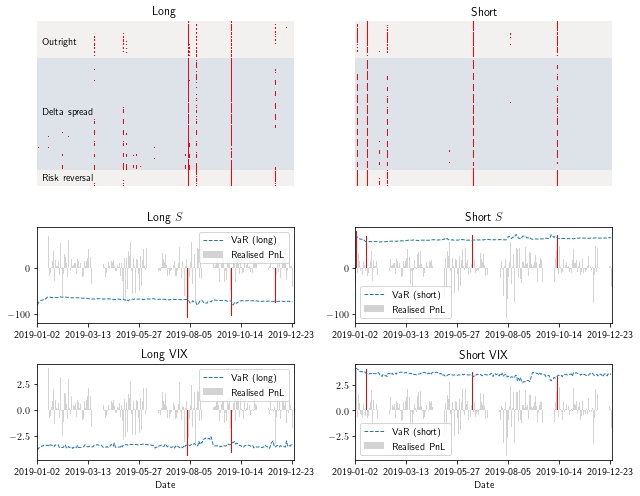

In [23]:
idxs_group_delta = [0, 1, 5]
idxs_group_deltaneutral = [2, 3, 4, 6]
idx_vix = 7
idx_S = 8

ls_ts_pnl = [ls_ts_pnl_[i] for i in idxs_group_delta]
ls_ts_var_long = [ls_ts_var_long_[i] for i in idxs_group_delta]
ls_ts_var_short = [ls_ts_var_short_[i] for i in idxs_group_delta]

ls_ts_breach_short = []
ls_ts_breach_long = []

ls_pnlvar_short = []
ls_pnlvar_long = []

for i in range(len(ls_ts_pnl)):
    ls_ts_breach_short.append(ls_ts_pnl[i] > ls_ts_var_short[i])
    ls_ts_breach_long.append(ls_ts_pnl[i] < ls_ts_var_long[i])
        
mat_breach_short = np.vstack(ls_ts_breach_short) * 1
mat_breach_long = np.vstack(ls_ts_breach_long) * 1


df0 = pd.DataFrame(mat_breach_long.T)
df0['date'] = dates_test[:n_test]
df0.set_index(['date'], inplace=True)

df1 = pd.DataFrame(mat_breach_short.T)
df1['date'] = dates_test[:n_test]
df1.set_index(['date'], inplace=True)

idxs_cut = np.cumsum([70,210,30])

S_ts_pnl = ls_ts_pnl_[idx_S]
S_ts_var_long = ls_ts_var_long_[idx_S]
S_ts_var_short = ls_ts_var_short_[idx_S]

vix_ts_pnl = ls_ts_pnl_[idx_vix]
vix_ts_var_long = ls_ts_var_long_[idx_vix]
vix_ts_var_short = ls_ts_var_short_[idx_vix]


dates = dates_test[:-mpor]
df2 = pd.DataFrame(data=np.vstack((S_ts_var_long, S_ts_var_short)).T,
                   columns=['VaR (long)', 'VaR (short)'],
                   index=dates)
df3 = pd.DataFrame(data=np.vstack((vix_ts_var_long, vix_ts_var_short)).T,
                   columns=['VaR (long)', 'VaR (short)'],
                   index=dates)

gridspec = GridSpec(7, 2)

fig = plt.figure(figsize=(9, 7))

ax = fig.add_subplot(gridspec[:3, 0])
ax.set_title('Long')
g = sns.heatmap(df0.T, ax=ax, xticklabels=35, yticklabels=False,
            cbar=False, cmap=sns.light_palette("red", as_cmap=True))
g.set_xticklabels(g.get_xticklabels(), rotation=20)
for i in range(len(idxs_cut)):
    if i%2 == 1:
        ax.axhspan(idxs_cut[i-1], idxs_cut[i], alpha=.1)
ax.text(5, 45, 'Outright')
ax.text(5, 175, 'Delta spread')
ax.text(5, 300, 'Risk reversal')
g.set_xticklabels([])
g.set_xticks([])
g.set_xlabel(None)

ax = fig.add_subplot(gridspec[:3, 1])
g = sns.heatmap(df1.T, ax=ax, xticklabels=35, yticklabels=False,
            cbar=False, cmap=sns.light_palette("red", as_cmap=True))
ax.set_title('Short')
for i in range(len(idxs_cut)):
    if i%2 == 1:
        ax.axhspan(idxs_cut[i-1], idxs_cut[i], alpha=.1)
g.set_xticklabels([])
g.set_xticks([])
g.set_xlabel(None)

ax = fig.add_subplot(gridspec[3:5, 0])
df2['VaR (long)'].plot(linestyle='--', linewidth=1, ax=ax)
ax.bar(dates, S_ts_pnl, color='lightgrey', label='Realised PnL')
mask_breach = (S_ts_pnl < S_ts_var_long)
ax.bar(dates[mask_breach], S_ts_pnl[mask_breach], color='red')
ax.legend(loc='upper right')
ax.set_xlim(g.get_xlim())
ax.set_title(r'Long $S$')

ax = fig.add_subplot(gridspec[3:5, 1])
df2['VaR (short)'].plot(linestyle='--', linewidth=1, ax=ax)
ax.bar(dates, S_ts_pnl, color='lightgrey', label='Realised PnL')
mask_breach = (S_ts_pnl > S_ts_var_short)
ax.bar(dates[mask_breach], S_ts_pnl[mask_breach], color='red')
ax.legend(loc='lower left')
ax.set_xlim(g.get_xlim())
ax.set_title(r'Short $S$')

ax = fig.add_subplot(gridspec[5:, 0])
df3['VaR (long)'].plot(linestyle='--', linewidth=1, ax=ax)
ax.bar(dates, vix_ts_pnl, color='lightgrey', label='Realised PnL')
mask_breach = (vix_ts_pnl < vix_ts_var_long)
ax.bar(dates[mask_breach], vix_ts_pnl[mask_breach], color='red')
ax.legend(loc='upper right')
ax.set_xlim(g.get_xlim())
ax.set_xlabel('Date')
ax.set_title(r'Long VIX')

ax = fig.add_subplot(gridspec[5:, 1])
df3['VaR (short)'].plot(linestyle='--', linewidth=1, ax=ax)
ax.bar(dates, vix_ts_pnl, color='lightgrey', label='Realised PnL')
mask_breach = (vix_ts_pnl > vix_ts_var_short)
ax.bar(dates[mask_breach], vix_ts_pnl[mask_breach], color='red')
ax.legend(loc='lower left')
ax.set_xlim(g.get_xlim())
ax.set_xlabel('Date')
ax.set_title(r'Short VIX')

plt.tight_layout()